<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S06_Time-Series_Analytics/Demo_Time_Series_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Time-series demand forecasting pipeline

## Introduction

Time series demand forecasting is crucial for effective supply chain management. With accurate demand forecasts, businesses can optimize inventory, improve demand planning, enhance sales forecasting, and mitigate supply chain risks.

With recent development in Python and opensources, there are many simple-to-use packages such as [statsmodels](https://www.statsmodels.org/stable/index.html) (mainly for statistical techniques), [Prophet (by Facebook)](https://facebook.github.io/prophet/), [GluonTS (by Amazon)] (https://ts.gluon.ai/stable/), and many other libraries. Most libraries require a specific (but similar) data input format and processes. Thus, the most important step to use such packages is to prepare the data in the right format.

There are also opensource libaries that are built upon many time-series forecasting packages and provide interfaces to many time-series algorithms such as [sktime](https://www.sktime.net/en/latest/index.html) and [darts](https://unit8co.github.io/darts/). These time-series forecasting interfaces greatly simplify forecasting with its intuitive API and diverse range of models, including classical statistical methods and modern machine learning approaches including deep-learning-based models. An illustration of a time-series pipeline based on the case [1] is depicted below. Note that, in the case, both time-series-based (which requires time-series data format) and machine-learning-based (which requires tabular data format) models are used simultaneously whereas this notebook focuses on the use of time-series models using time-series data format.

<figure>
<center>
<img src='https://github.com/acedesci/scanalytics/blob/master/EN/S06_Time-Series_Analytics/BBD_forecasts.png?raw=true'/>
<figcaption>Forecasting pipeline as depicted in [1]</figcaption></center>
</figure>

This notebook provide a simple walkthrough for an implementation of time-series forecasting pipeline using `darts`. At the end of the notebook, it also demonstrates time-phased dynamic inventory policy that can be calculated from the forecasts from various forecasting models. The quality of this inventory policy can then be measured through a simulation which has been covered in an earlier session on `DataFrame`.

[1] Dodin, P., Xiao, J., Adulyasak, Y., Alamdari, N.E., Gauthier, L., Grangier, P., Lemaitre, P. and Hamilton, W.L., 2023. **Bombardier aftermarket demand forecast with machine learning.** *INFORMS Journal on Applied Analytics*, 53(6), pp.425-445.

**Code block description**: We first install `darts` (this must be run every time a new colab notebook is open).

In [ ]:
!pip install darts

## Data inputs

This code block primarily  sets up the environment for time series analysis using models available in `darts`.

*Notable remarks:*

*   `data = pd.read_csv(..., index_col='ds')`: Reads time series data from a CSV file located at the given URL. It assumes the file has a column named 'ds' that represents the dates or timestamps and sets it as the index of the DataFrame.

*   `y = data['y']`: Extracts the time series data (likely the demand values) from the 'y' column of the DataFrame and assigns it to the variable y.

*   `plot_n_points = 104 `: Sets the number of data points to be used for plotting.

*   `test_n_points = 65`: Sets the number of data points to be used for testing the forecasting models.

In [2]:
import darts
from darts.models import AutoARIMA, Prophet, ExponentialSmoothing, Theta, NaiveSeasonal, Croston, NBEATSModel
from darts.models import NaiveEnsembleModel, RegressionEnsembleModel
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape, mase, rmsse, rmse, merr
from darts import TimeSeries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# read historical time-series data (demand)
data = pd.read_csv('https://bit.ly/m5simple', index_col='ds')
data.index = pd.to_datetime(data.index)
n_periods = len(data.index)
print("Number of periods: " + str(n_periods))
# obtain the series of time series from column 'y'
y = data['y']

# number of historical data points to show on the plots (in weeks)
plot_n_points = 104

# number of data points used as the test set
test_n_points = 26


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Number of periods: 177


## Define key functions

This code block defines the following functions that will be called often in the pipeline.

**Function** `calculate_test_errors`:

This function calculates and return various error metrics for a time series forecast.

Input:

`test_series`: The actual values of the time series during the testing period.
`forecast_series`: The predicted values generated by a forecasting model during the testing period.

Process:

It uses functions from the darts.metrics module (`mape, smape, rmsse, rmse, merr`) to calculate the following error metrics (see [Darts error metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.html)):


* MAPE: Mean Absolute Percentage Error (from function `mape`)
* sMAPE: Symmetric Mean Absolute Percentage Error (from function `smape`)
* RMSSE: Root Mean Squared Scaled Error (from function `rmsse`)
* RMSE: Root Mean Squared Error (from function `rmse`)
* ME: Mean Error (from function `merr`)
* Norm_ME: Mean Error normalized by the mean of actual demand

Output:
The function returns the errors DataFrame containing the calculated error metrics for the model.

**Function** `add_ranks`:

This function is used to add rank columns to a DataFrame based on the values in existing columns, It returns the modified DataFrame with the added rank columns.

In [3]:
# functions to return test errors

def calculate_test_errors(test_series, forecast_series, series_name = 'y', print_results = False, skip_mape = False):
  # get the model name (the series from dart include the name of the model as the name of the series)
  m_name = forecast_series.name

  # convert the series of test set (actual values) and forecast set (forecasted values) into darts TimeSeries objects
  # (since we will use darts methods to calculate the errors)
  test = TimeSeries.from_series(test_series)
  forecast = TimeSeries.from_series(forecast_series)

  # In some cases, we need to skip MAPE if we have a zero demand observation since we cannot divide the error by zero
  # this is currently done manually. In any case, darts will also return an error if there is a zero demand when calculating mape.
  # The following part calculates all the forecasting errors we want to measure
  if not skip_mape:
    m_mape = mape(test, forecast)
    m_smape = smape(test, forecast)

  m_rmsse = rmsse(test, forecast, insample = train)
  m_rmse = rmse(test, forecast)
  m_merr = merr(test, forecast)

  if print_results:
    if not skip_mape:
      print(f"model {m_name} obtains Mean Absolute Percentage Error: {m_mape:.2f}%")
      print(f"model {m_name} obtains symmetric Mean Absolute Percentage Error: {m_smape:.2f}%")

    print(f"model {m_name} obtains Root Mean Squared Scaled Error: {m_rmsse:.2f}")
    print(f"model {m_name} obtains Root Mean Squared Error: {m_rmse:.2f}")
    print(f"model {m_name} obtains Mean Error: {m_merr:.2f}")

  # Now we put together the errors in the dataframe 'errors'=
  test_mean = test.pd_series().mean()

  if not skip_mape:
    column_names=['SeriesName', 'Model', 'MAPE', 'sMAPE', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
    errors = pd.DataFrame(columns=column_names)
    errors.loc[0] = [series_name, m_name, m_mape, m_smape, m_rmsse, m_rmse, m_rmse/test_mean, m_merr, m_merr/test_mean]
  else:
    column_names=['SeriesName', 'Model', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
    errors = pd.DataFrame(columns=column_names)
    errors.loc[0] = [series_name, m_name, m_rmsse, m_rmse, m_rmse/test_mean, m_merr, m_merr/test_mean]

  return errors

In [4]:
# This function takes a DataFrame of the error values and then return the ranking of the results based on the obsolute values
# (the lower the value the higher the rank)
def add_ranks(df, ascending=True):
  for col in df.columns[2:]:
    df['Rank_'+col] = df[col].abs().rank(ascending=ascending)
  return df

## Pipeline 1: Forecasting and evaluation using two-fold validation

The code block calls and evaluates various time series forecasting models in the `darts` library. It first prepares the data, visualizes the actual values, and defines a list of forecasting models, including ensembles. Then, it iteratively trains each model, generates forecasts, calculates error metrics. Finally, it combines and displays the errors and ranks of each model, providing a performance comparison based on different models for the given dataset.

The training and evaluation of this pipeline is based on a two-fold validation process where data is split only into one training and one test set at a given split point. The predictions are evaluated against the actual values in the test set (which is not used in the training process).


Forecast using model:  NaiveSeasonal(K=52)
Forecast using model:  ExponentialSmoothing(seas
Forecast using model:  ExponentialSmoothing()
Forecast using model:  AutoARIMA()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpetr30ak3/4oajbvj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpetr30ak3/sec4un_0.json


Forecast using model:  Prophet()


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8173', 'data', 'file=/tmp/tmpetr30ak3/4oajbvj9.json', 'init=/tmp/tmpetr30ak3/sec4un_0.json', 'output', 'file=/tmp/tmpetr30ak3/prophet_modeluplzo534/prophet_model-20250209044737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast using model:  NaiveEnsembleModel(foreca
Forecast using model:  RegressionEnsembleModel(f


,SeriesName,Model,MAPE,sMAPE,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,Rank_MAPE,Rank_sMAPE,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME
0,y,NaiveSeasonal(K=52),7.818233,8.084153,0.803072,342.678757,0.091440,161.961538,0.043218,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,y,ExponentialSmoothing(seas,11.218291,10.501889,1.071165,457.076816,0.121966,-341.883301,-0.091228,6.0,6.0,6.0,6.0,6.0,6.0,6.0
2,y,ExponentialSmoothing(),4.823138,4.715174,0.519729,221.773349,0.059178,-87.728160,-0.023409,1.0,1.0,1.0,1.0,1.0,2.0,2.0
3,y,AutoARIMA(),11.938415,11.121139,1.137719,485.475830,0.129544,-376.174725,-0.100378,7.0,7.0,7.0,7.0,7.0,7.0,7.0
4,y,Prophet(),7.433607,7.127601,0.779534,332.634812,0.088760,-144.078678,-0.038446,4.0,4.0,4.0,4.0,4.0,4.0,4.0
5,y,NaiveEnsembleModel(foreca,6.262698,6.139869,0.651899,278.171735,0.074227,-84.653230,-0.022589,2.0,2.0,2.0,2.0,2.0,1.0,1.0
6,y,RegressionEnsembleModel(f,7.121622,6.931025,0.732658,312.632439,0.083423,-124.865848,-0.033319,3.0,3.0,3.0,3.0,3.0,3.0,3.0


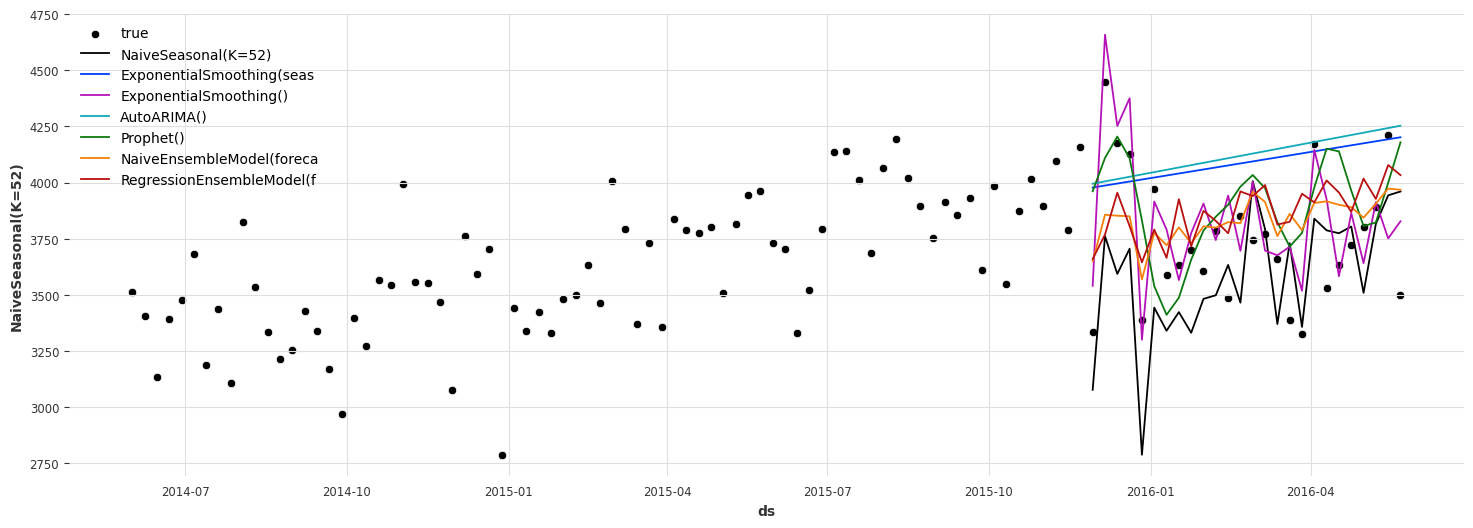

In [5]:
# Single split (two-fold)

# Create a plot the time-series and plot the actual values (both the train and test)
plt.figure(figsize=(18,6))
sns.scatterplot(x = y[-plot_n_points:].index, y = y[-plot_n_points:].values, label = 'true')

# Convert the series y into Darts's TimeSeries object (so that we can use darts methods)
y_timeseries = TimeSeries.from_series(y)

# We will also try an ensemble model that combines the foorecast of the following, methods
ensemble_models = [NaiveSeasonal(K=52), Theta(season_mode = SeasonalityMode.ADDITIVE), Croston()]

# Here is the list of the models (all supported by darts) and their corresponding input parameters we will run
list_models = [NaiveSeasonal(K=52), \
               ExponentialSmoothing(seasonal=None), \
               ExponentialSmoothing(), \
               AutoARIMA(), \
               # Theta(), \
               Prophet(), \
               # NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50), \
               # Croston(),\
               NaiveEnsembleModel(forecasting_models=ensemble_models), \
               RegressionEnsembleModel(forecasting_models=ensemble_models, regression_train_n_points=13)]

# We will prepare the list of errors that will contain the errors from each model to compare.
# This errors will be put together in a dataframe 'pd_errors' later on
list_errors = []

# We will also prepare a DataFrame that contains all the forecasts
df_forecasts = pd.DataFrame()

# We first add the first column based on the actual data
df_forecasts['y'] = y

# 'start' here define the split between the training and test periods
start = len(y)-test_n_points
# Now we split the train and test at the start point (of the test)
train, test = y_timeseries.split_before(start)

# Now we perform the forecast using one model in each loop, and calculate the forecasting errors
# The results are then added to the DataFrame 'df_forecasts'
for model in list_models:
  # First, we use the first 15 characters of the name of the model as the name to be displayed to DataFrame
  # (some names are too long so we cut only the first 15 characters)
  m_name = str(model)[:25]
  print("Forecast using model: ", m_name)

  # Train (fit) the mode using the training set
  model.fit(train)

  # Predict for the next 'test_n_points' and then convert the outputs (which is Darts TimeSeries object) into a series
  forecast_series = model.predict(test_n_points).pd_series()
  # Set the name of the series to the name of the model
  forecast_series.name = m_name
  # Now call the function to calculate all the errors
  errors = calculate_test_errors(test.pd_series(), forecast_series, series_name = 'y')
  # Add the forecast plot from this model to the time-series plot
  sns.lineplot(data = forecast_series, label = forecast_series.name)
  # Append the errors (list) into 'list_errors'
  list_errors.append(errors)
  # Add the forecast to 'df_forecasts' that store the forecasts of all the models
  df_forecasts[forecast_series.name] = forecast_series

# Once finished, we then convert the list of list of errors into a DataFrame
pd_errors = pd.concat(list_errors, ignore_index = True)

# We then add the columns to show the rankings based on the performances of the forecasts of different models
pd_errors = add_ranks(pd_errors)

pd_errors

## Define rolling forecasts and plot functions

**Function** `eval_model_rolling_forecasts`:

This function simulates a real-world forecasting scenario where one would retrain the model periodically with new data to make future predictions. It provides a more realistic evaluation of the model's performance over time compared to a single train-test split. This functions requires the **following inputs**:

* `model`: darts models (see [darts forecasting models](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html))
* `series`: a series containing the entire time-series data
* `start`: the first starting point of the forecasting evaluation
* `fh`: length of the forecast horizon
* `stride`: the retraining (forecast update) internal (i.e., new forecasts are produced every `stride` periods). This value must be $\leq$ `fh`

The model returns a series containing the predictions that are produced using a rolling update of every `stride` periods. Only the most recent values of the predictions are kept in the series.

**Function** `plot_forecasts`:

 This function is used to visualize time series data from a DataFrame containing actual and forecasted data.It generates a plot with actual values displayed as scatter points and forecasts from different models represented as lines.

In [6]:
def eval_model_rolling_forecasts(model, series, start, fh, stride, series_name = 'y'):
  # Get the name of the model
  m_name = str(model)[:15]
  # Create a Darts's Timeseries object from the time-series inputs
  timeseries = TimeSeries.from_series(series)
  # Create list which contains the forecasts in different folds
  list_hist_rolling_forecasts = []
  # Each fold starts from 'starting_point' that moves forward by 'stride' periods in each fold.
  # The length of the forecast in each fold is 'fh'
  # Fold 1 [----fh----]
  # Fold 2 -stride-|[----fh----]
  # Fold 3 -stride-|-stride-|[----fh----]
  for starting_point in range(start, len(timeseries), stride):
    # Split the train and each fold of test at the starting_point of that fold
    train, test = timeseries.split_before(starting_point)
    # Check if the forecast horizon 'fh' is shorter than the length of time series
    forecast_horizon = min(fh, len(test))
    # We then fit the model and predict for the next 'forecast_horizon' periods
    forecasts = model.fit(train).predict(forecast_horizon)
    # Now the results are added to the list of the rolling forecasts
    list_hist_rolling_forecasts.append(forecasts.pd_series())

  # Here we combine the forecasts of all folds using only the most updated forecasts
  # We first start from the last folds
  last_fold = len(list_hist_rolling_forecasts)-1
  hist_rolling_forecasts = list_hist_rolling_forecasts[last_fold]

  # Then added the forecasts backward (so that the forecasts are from the most recent folds)
  for fold in range(last_fold):
    hist_rolling_forecasts = pd.concat([hist_rolling_forecasts, list_hist_rolling_forecasts[fold][:stride]])

  hist_rolling_forecasts.name = m_name
  print("\t----- generating rolling forecasts using model " +str(hist_rolling_forecasts.name))

  # return the forecasts from this rolling forecast
  return hist_rolling_forecasts


In [7]:
# This is a function to plot the forecasts from the DataFrame containing the data and the forecasts

def plot_forecasts(df_forecasts, n_points, series_name = 'y', plot_name = 'Prediction'):
  plt.figure(figsize=(18,6))
  plt.title(plot_name+": " + series_name)
  plt.xlabel("Date")
  plt.ylabel("Value")
  y = df_forecasts['y']
  sns.scatterplot(x = y[-n_points:].index, y = y[-n_points:].values, label = 'true')

  for model in df_forecasts.columns[1:]:
    sns.lineplot(data = df_forecasts[model][-n_points:], label = model)


## Pipeline 2: Forecasting and evaluation using sequential validation

This code block is similar to pipeline 1 but it simulates and evaluates the forecasts on a rolling basis using the previously defined function `eval_model_rolling_forecasts(...)`.

	----- generating rolling forecasts using model NaiveSeasonal(K
	----- generating rolling forecasts using model ExponentialSmoo
	----- generating rolling forecasts using model AutoARIMA()
	----- generating rolling forecasts using model Theta()
	----- generating rolling forecasts using model Croston()
	----- generating rolling forecasts using model NaiveEnsembleMo
	----- generating rolling forecasts using model RegressionEnsem


,SeriesName,Model,MAPE,sMAPE,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,Rank_MAPE,Rank_sMAPE,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME
0,y,NaiveSeasonal(K,10.674152,11.390269,0.993654,466.298798,0.122831,353.769231,0.093189,7.0,7.0,7.0,7.0,7.0,7.0,7.0
0,y,ExponentialSmoo,7.424452,7.331719,0.726633,340.991987,0.089823,-67.934413,-0.017895,6.0,6.0,6.0,6.0,6.0,5.0,5.0
0,y,AutoARIMA(),6.901420,6.787874,0.663463,311.347702,0.082014,-54.258305,-0.014293,4.0,4.0,4.0,4.0,4.0,3.0,3.0
0,y,Theta(),6.814157,6.746608,0.651858,305.901789,0.080580,-32.447474,-0.008547,3.0,3.0,3.0,3.0,3.0,1.0,1.0
0,y,Croston(),6.421460,6.491812,0.630310,295.790037,0.077916,63.358560,0.016690,2.0,2.0,2.0,2.0,2.0,4.0,4.0
0,y,NaiveEnsembleMo,6.173818,6.357114,0.622906,292.315289,0.077001,128.688690,0.033899,1.0,1.0,1.0,1.0,1.0,6.0,6.0
0,y,RegressionEnsem,7.114506,7.057938,0.712071,334.158307,0.088023,-40.791643,-0.010745,5.0,5.0,5.0,5.0,5.0,2.0,2.0


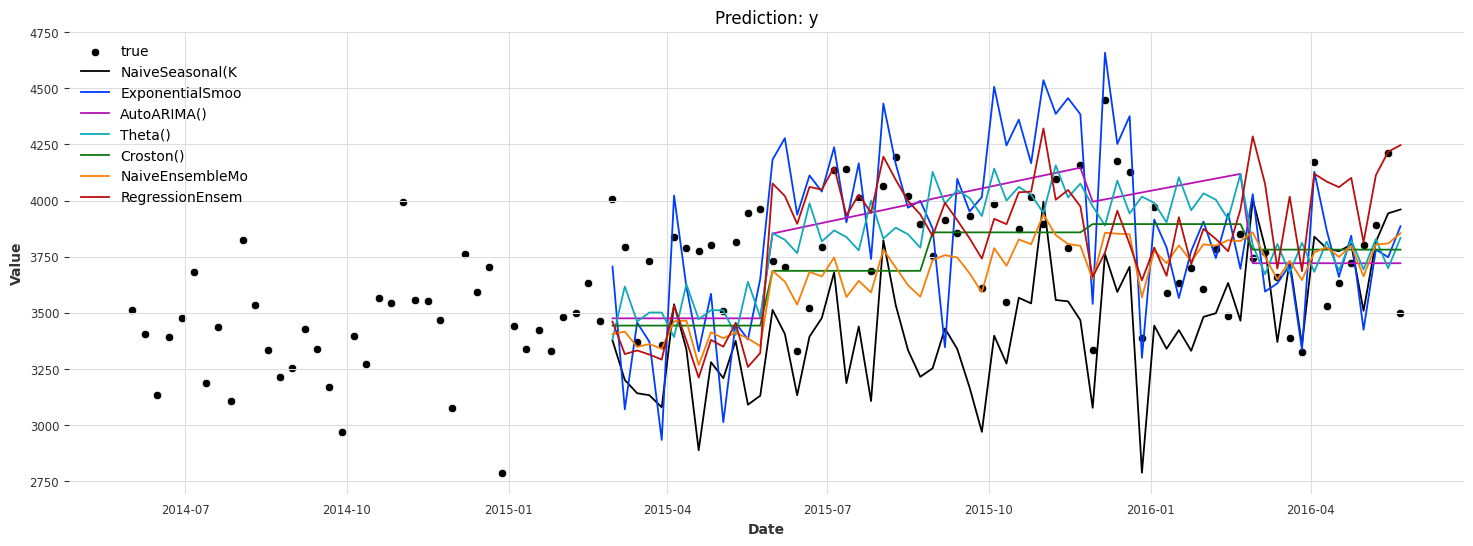

In [8]:
# Rolling forecasts evaluation (multifold sequential validation)

# Now we increase the test length to 1 year + 1 quarter and use sequential validation
# Note that some methods that capture seasonality requires 2 periods (years) of data
# Thus, the training set cannot be shorter than 2 seasonality cycles
test_n_points = 65

y_timeseries = TimeSeries.from_series(y)
start = len(y)-test_n_points
fh = 13
stride=13

#  List of models for ensemble methods
ensemble_models = [NaiveSeasonal(K=52), Theta(season_mode = SeasonalityMode.ADDITIVE), Croston()]

# List of models
list_models = [NaiveSeasonal(K=52),
               ExponentialSmoothing(),
               AutoARIMA(), \
               Theta(), \
               # Prophet(), \
               # NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50), \
               Croston(),\
               NaiveEnsembleModel(forecasting_models=ensemble_models), \
               RegressionEnsembleModel(forecasting_models=ensemble_models, regression_train_n_points=13)
               ]

list_errors = []
df_forecasts = pd.DataFrame()
df_forecasts['y'] = y
train, test = y_timeseries.split_before(start)

# Now we perform the forecast using one model in each loop, and calculate the forecasting errors
# The results are then added to the DataFrame 'df_forecasts'
for model in list_models:
  forecast_series = eval_model_rolling_forecasts(model, y, start, fh, stride)
  errors = calculate_test_errors(test.pd_series(), forecast_series)
  list_errors.append(errors)
  df_forecasts[forecast_series.name] = forecast_series

pd_errors = pd.concat(list_errors)
pd_errors = add_ranks(pd_errors)

plot_forecasts(df_forecasts, plot_n_points)

pd_errors

## Pipeline 3: Automating forecasting and sequential validation on multiple items

This code block is similar to pipeline 2 that performs rolling forecasts. The code automate the predictions of multiple items through iterative process.

In [9]:
# pipeline to run forecast for multiple items

import time

# state-item level
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/processed_data/m5data_CA_item_state_rand.csv'

# store-item level (slow-moving)
# url = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/processed_data/m5data_CA_item_store_n25_cv.csv'

data = pd.read_csv(url, index_col='ds')
data.index = pd.to_datetime(data.index)

list_items = data.columns[:3]
print("list of items: " + str(list_items))

test_n_points = 65
start = len(data.index)-test_n_points
fh = 13
stride = 13

# Note that there are some slow-moving items with zero demands. Thus, we need to specify
# 'season_mode = SeasonalityMode.ADDITIVE' for Theta() since the default version used
# multiplicative seasonality that will return error when the demand is zero
ensemble_models = [NaiveSeasonal(K=52), Theta(season_mode = SeasonalityMode.ADDITIVE), Croston()]

list_models = [NaiveSeasonal(K=52),
               ExponentialSmoothing(),
               # AutoARIMA(), \
               Theta(season_mode = SeasonalityMode.ADDITIVE), \
               # Prophet(), \
               # NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50), \
               Croston(),\
               NaiveEnsembleModel(forecasting_models=ensemble_models), \
               RegressionEnsembleModel(forecasting_models=ensemble_models, regression_train_n_points=13)
               ]

pd_all_errors = pd.DataFrame()

list_forecasts = []

# Iterate through each item (time-series) in the list of items
for item in list_items:

  print("Item: "+str(item))
  y = data[item]
  df_forecasts = pd.DataFrame()
  df_forecasts['y'] = y

  y_timeseries = TimeSeries.from_series(y)
  train, test = y_timeseries.split_before(start)

  list_errors = []

  # For each item, perform the forecast using one model in each loop, and calculate the forecasting errors
  # The results are then added to the DataFrame 'df_forecasts'
  # We also measure the runtime of the forecasts (as some methods can be quite time consuming)
  for model in list_models:
    # Set the start time
    start_time = time.time()
    forecast_series = eval_model_rolling_forecasts(model, y, start, fh, stride, series_name = item)
    # Calculate the runtime used by the model
    runtime = time.time()-start_time
    forecast_series = forecast_series.clip(lower=0)
    errors = calculate_test_errors(test.pd_series(), forecast_series, series_name = item, skip_mape = True)
    # Add the runtime to the dataframe of errors (to the colume 'runtime')
    errors['runtime'] = [runtime]
    list_errors.append(errors)
    df_forecasts[forecast_series.name] = forecast_series

  pd_errors = add_ranks(pd.concat(list_errors))

  pd_all_errors = pd.concat([pd_all_errors, pd_errors])
  list_forecasts.append(df_forecasts)

list of items: Index(['CA_HOBBIES_1_002', 'CA_HOBBIES_1_004', 'CA_HOBBIES_1_005'], dtype='object')
Item: CA_HOBBIES_1_002
	----- generating rolling forecasts using model NaiveSeasonal(K
	----- generating rolling forecasts using model ExponentialSmoo
	----- generating rolling forecasts using model Theta(season_mo
	----- generating rolling forecasts using model Croston()
	----- generating rolling forecasts using model NaiveEnsembleMo
	----- generating rolling forecasts using model RegressionEnsem
Item: CA_HOBBIES_1_004
	----- generating rolling forecasts using model NaiveSeasonal(K
	----- generating rolling forecasts using model ExponentialSmoo
	----- generating rolling forecasts using model Theta(season_mo
	----- generating rolling forecasts using model Croston()
	----- generating rolling forecasts using model NaiveEnsembleMo
	----- generating rolling forecasts using model RegressionEnsem
Item: CA_HOBBIES_1_005
	----- generating rolling forecasts using model NaiveSeasonal(K
	----- gener

In [10]:
# show the errors from all the models for each item
pd_all_errors

,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,runtime,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME,Rank_runtime
0,CA_HOBBIES_1_002,NaiveSeasonal(K,0.793161,3.355822,0.634094,-0.892308,-0.168605,0.040796,3.0,3.0,3.0,5.0,5.0,1.0
0,CA_HOBBIES_1_002,ExponentialSmoo,0.706972,2.991162,0.565190,-0.487227,-0.092063,0.956898,2.0,2.0,2.0,2.0,2.0,6.0
0,CA_HOBBIES_1_002,Theta(season_mo,0.842698,3.565411,0.673697,-0.105700,-0.019972,0.151352,4.0,4.0,4.0,1.0,1.0,3.0
0,CA_HOBBIES_1_002,Croston(),0.920904,3.896297,0.736219,-0.833177,-0.157432,0.046755,5.0,5.0,5.0,4.0,4.0,2.0
0,CA_HOBBIES_1_002,NaiveEnsembleMo,0.695761,2.943729,0.556228,-0.610395,-0.115336,0.213392,1.0,1.0,1.0,3.0,3.0,4.0
0,CA_HOBBIES_1_002,RegressionEnsem,3.231055,13.670420,2.583073,-5.611671,-1.060345,0.632615,6.0,6.0,6.0,6.0,6.0,5.0
0,CA_HOBBIES_1_004,NaiveSeasonal(K,1.363026,25.760435,0.290045,-14.369231,-0.161788,0.042344,6.0,6.0,6.0,5.0,5.0,2.0
0,CA_HOBBIES_1_004,ExponentialSmoo,0.884624,16.718906,0.188243,-7.021538,-0.079058,0.829690,3.0,3.0,3.0,1.0,1.0,6.0
0,CA_HOBBIES_1_004,Theta(season_mo,0.863101,16.312129,0.183663,-7.508196,-0.084537,0.095906,2.0,2.0,2.0,3.0,3.0,3.0
0,CA_HOBBIES_1_004,Croston(),0.857175,16.200135,0.182402,-7.271757,-0.081875,0.027771,1.0,1.0,1.0,2.0,2.0,1.0


In [11]:
# show the average errors from all the models across all the items
pd_all_errors[pd_all_errors.columns[1:]].groupby('Model').mean().sort_values(by=['Rank_RMSSE'])

,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,runtime,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME,Rank_runtime
Model,,,,,,,,,,,,
ExponentialSmoo,0.874625,9.667201,0.329539,-2.573423,-0.058825,0.829997,2.000000,2.000000,2.000000,1.333333,1.333333,6.000000
Theta(season_mo,0.917561,9.766846,0.365290,-1.637720,-0.012050,0.117449,2.666667,2.666667,2.666667,2.333333,2.333333,3.000000
Croston(),0.963908,10.040117,0.390781,-1.185680,-0.041398,0.034130,3.000000,3.000000,3.000000,3.333333,3.333333,1.666667
NaiveEnsembleMo,0.961547,10.490112,0.347172,-0.754809,-0.006888,0.177626,3.333333,3.333333,3.333333,4.000000,4.000000,4.000000
NaiveSeasonal(K,1.440443,16.201571,0.472474,0.558974,0.032782,0.036306,5.000000,5.000000,5.000000,5.333333,5.333333,1.333333
RegressionEnsem,1.941289,16.732840,1.051252,-8.236740,-0.431152,0.480161,5.000000,5.000000,5.000000,4.666667,4.666667,5.000000


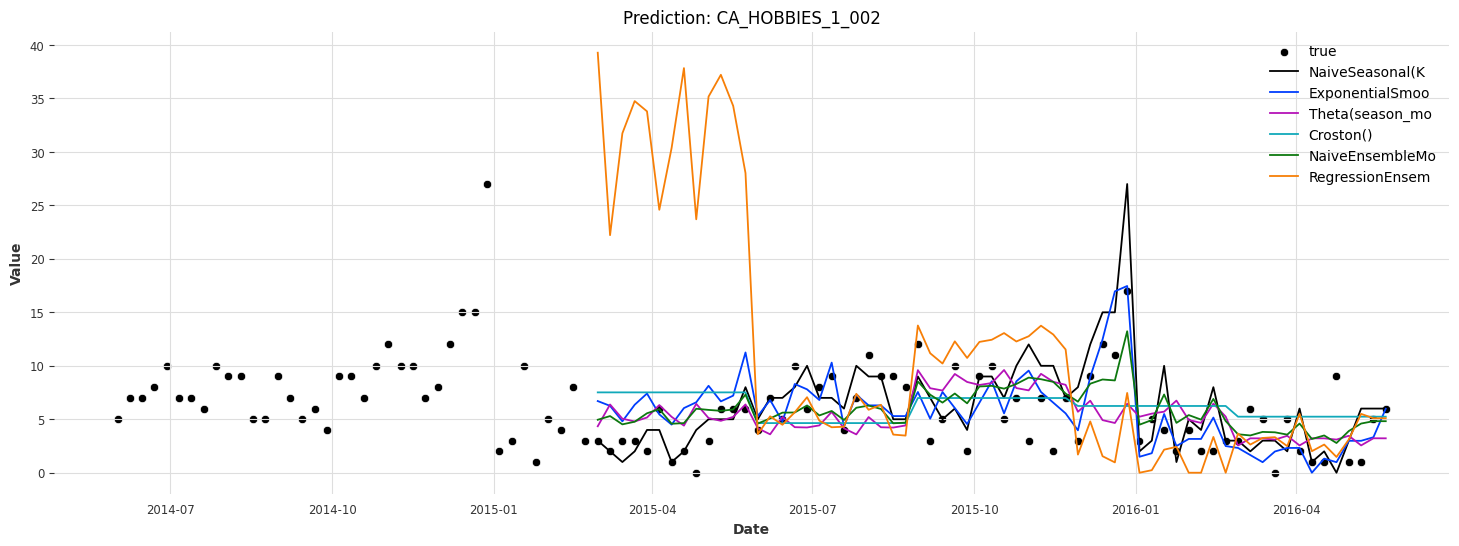

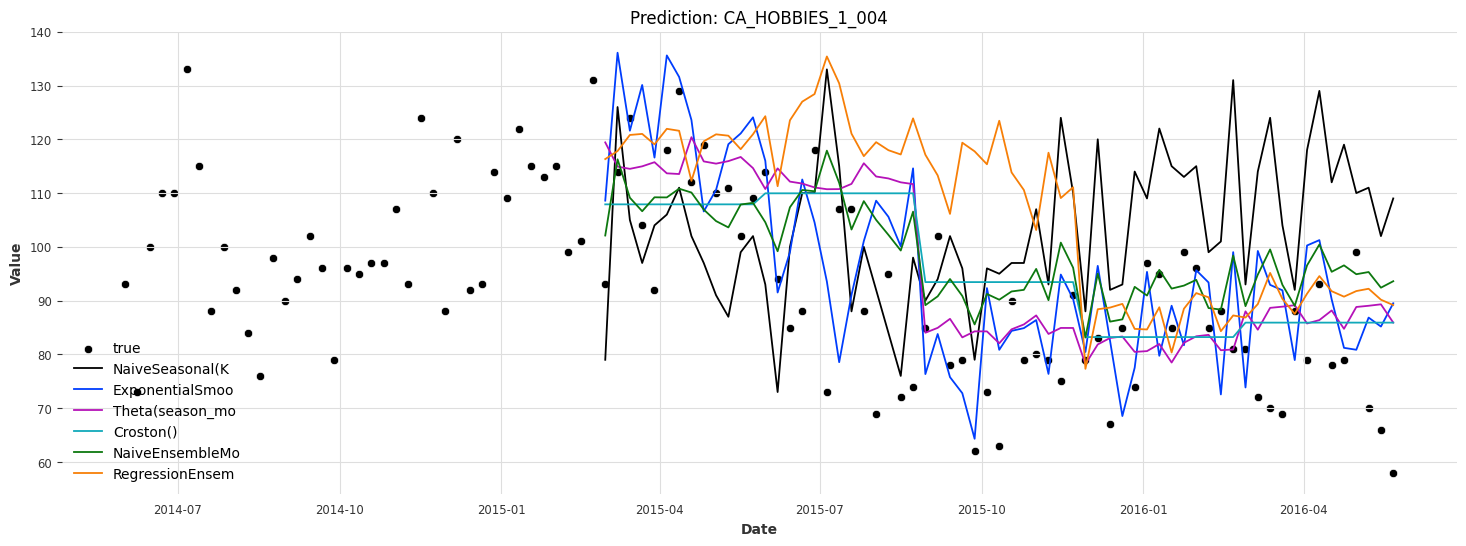

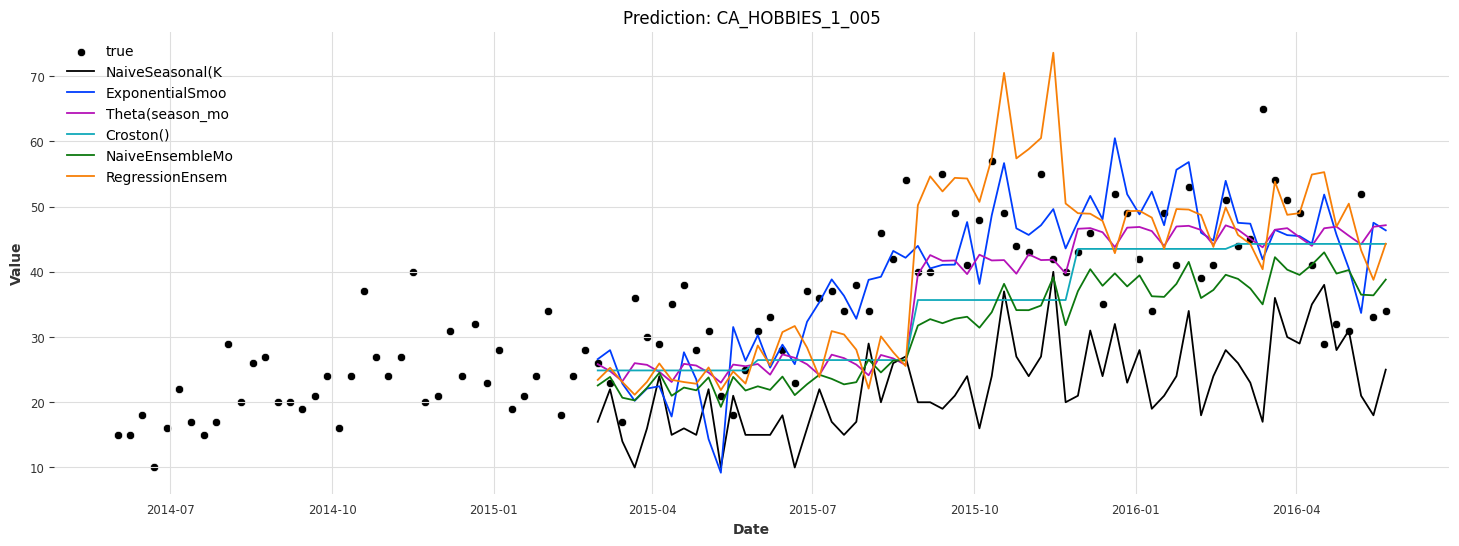

In [12]:
for i, item in enumerate(list_items[:10]):
  plot_forecasts(list_forecasts[i], plot_n_points, series_name = item)

## Extra: Dynamic inventory policy from forecasts

The code calculates a dynamic basestock inventory policy using previously generated demand forecasts from various models. In this basestock inventory policy, we assume that the stock must be replenished to the target level ($S_t$) at every replenishment period. This target stock level must ensure that the inventory position (on-hand inventory + in-transit inventory) is sufficient to cover the forecasted demands and safety stock during the supply lead time. More specifically, the dynamic basestock (target) inventory level at time $t$, denoted by $S_t$, is calculated by:

$S_t = \sum_{k=t+1}^{t+L}F_k+SS_t$

where $F_t$ is the forecast of the item at time $t$, $L$ is the lead time, and $SS_t$ is the dynamic safety stock at time $t$ calculated as follows:

$SS_t = z\times RMSE \times \sqrt{L}$

where $RMSE$ is the standard deviation of the forecasting errors (i.e., root mean squared error). This value is calculated from the reference (initial) periods prior to rolling forecasts of that iteration defined by the parameter `n_periods_fcst_errors`. The evaluation of the inventory policy starts from the period following the end of the initial periods.

Finally, the code visualizes both the original demand forecasts and the calculated target stock levels against the ideal target stock levels based on the actual demands.

<ipython-input-13-2afccaf6a81d>:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  target_stocks['y'].iloc[starting_period] = actual_leadtime_demand
<ipython-input-13-2afccaf6a81d>:38: FutureWarning: ChainedAssignmentError: behaviour will cha

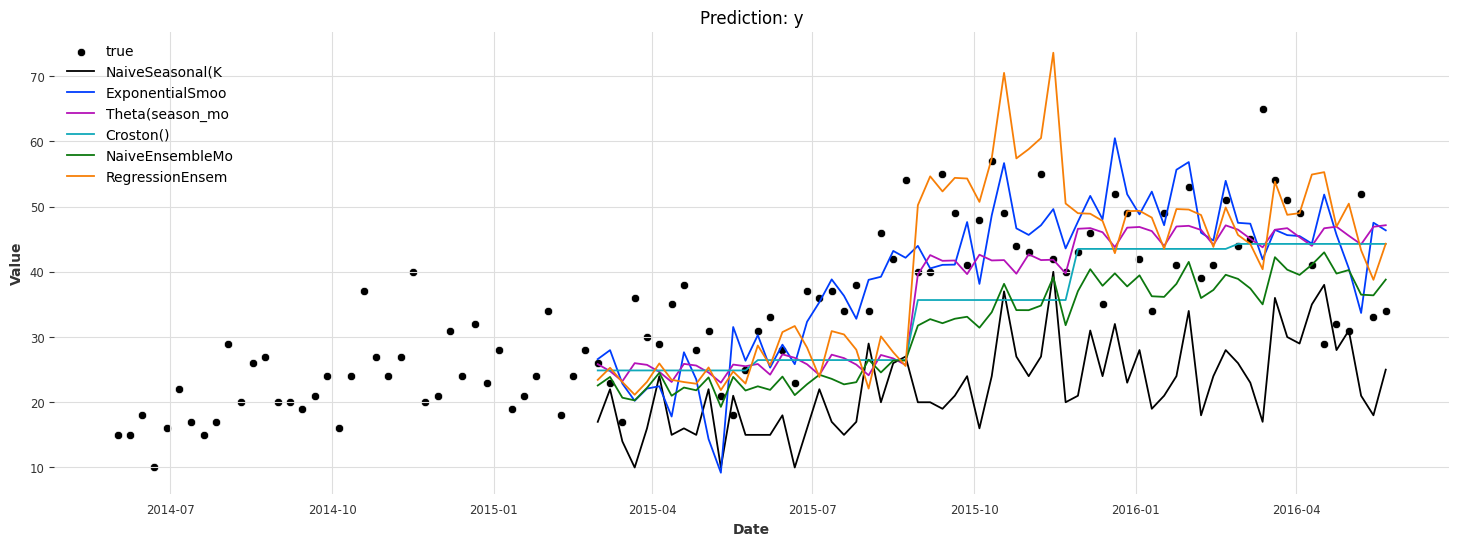

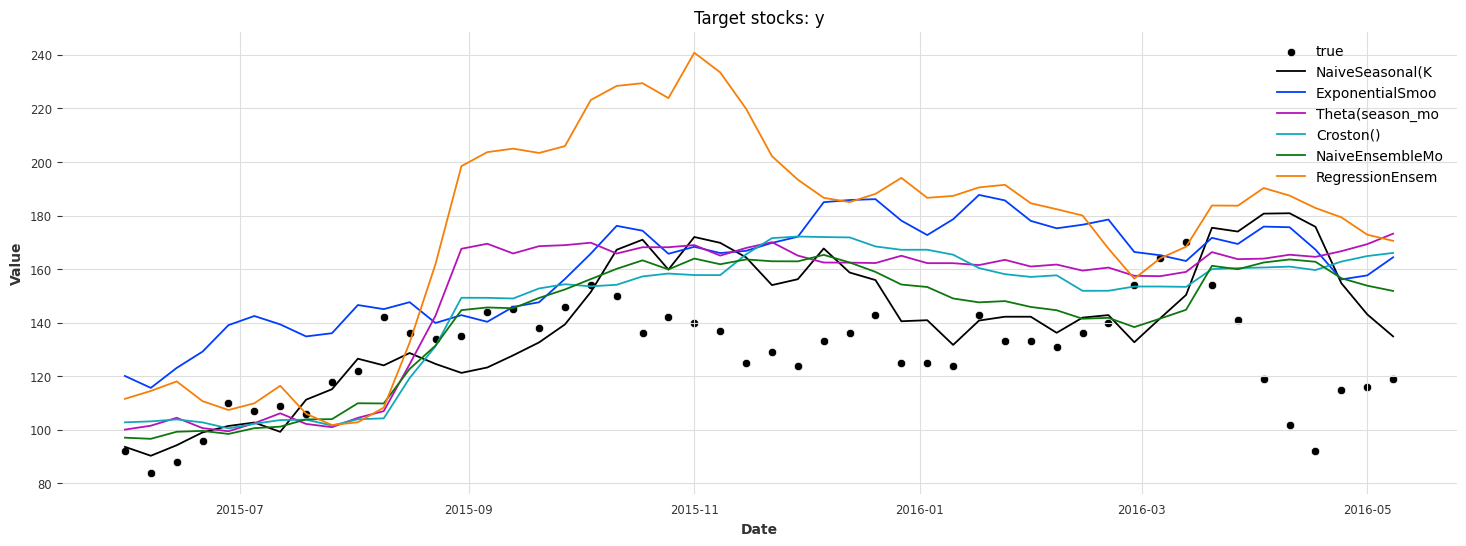

In [13]:
# dynamic basestock policy simulation

import numpy as np

item_index = 2

forecasts = list_forecasts[item_index][-test_n_points:]
forecast_models = forecasts.columns[1:]

# This is the reference period used to calculate RMSE for safety stocks
n_periods_fcst_errors = 13

leadtime = 3
z_score = 1.96

test_forecasts = forecasts[n_periods_fcst_errors:]

# prepare the dataframe for the target stock values for each time period that will be calculated
target_stocks = pd.DataFrame(index = test_forecasts.index, columns = test_forecasts.columns)

hist_rmse = []

list_errors = []

# calculate the (dynamic) target stock levels for each period in the test periods
for starting_period in range(len(test_forecasts.index)-leadtime+1):
  initial_forecasts = forecasts[starting_period:starting_period+n_periods_fcst_errors]

  actual_leadtime_demand = sum(test_forecasts['y'].iloc[starting_period: starting_period+leadtime])
  target_stocks['y'].iloc[starting_period] = actual_leadtime_demand

  for model in forecast_models:
    squared_diff = (initial_forecasts['y'] - initial_forecasts[model])**2
    rmse_val = (np.mean(squared_diff))**(1/2)

    exp_leadtime_demand = sum(test_forecasts[model].iloc[starting_period: starting_period+leadtime])
    safety_stock = z_score*rmse_val*(leadtime)**(1/2)
    target_stocks[model].iloc[starting_period] = exp_leadtime_demand + safety_stock
    # print("Model["+str(model)+"], SS: "+str(safety_stock))

plot_forecasts(list_forecasts[item_index], plot_n_points)
plot_forecasts(target_stocks, plot_n_points, plot_name = 'Target stocks')


In [14]:
# Retrieve and display the forecasting performances for this item based on different models
item = list_items[item_index]
pd_all_errors[pd_all_errors['SeriesName'] == item]

,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,runtime,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME,Rank_runtime
0,CA_HOBBIES_1_005,NaiveSeasonal(K,2.165143,19.488458,0.493283,16.938462,0.428738,0.025779,6.0,6.0,6.0,6.0,6.0,1.0
0,CA_HOBBIES_1_005,ExponentialSmoo,1.032278,9.291535,0.235183,-0.211506,-0.005354,0.703403,1.0,1.0,1.0,1.0,1.0,6.0
0,CA_HOBBIES_1_005,Theta(season_mo,1.046883,9.422998,0.238510,2.700736,0.068360,0.105089,2.0,2.0,2.0,3.0,3.0,3.0
0,CA_HOBBIES_1_005,Croston(),1.113645,10.023919,0.253721,4.547893,0.115114,0.027865,3.0,3.0,3.0,4.0,4.0,2.0
0,CA_HOBBIES_1_005,NaiveEnsembleMo,1.297373,11.677659,0.295579,8.062364,0.204071,0.156106,5.0,5.0,5.0,5.0,5.0,4.0
0,CA_HOBBIES_1_005,RegressionEnsem,1.260259,11.343592,0.287124,-1.286353,-0.032560,0.342805,4.0,4.0,4.0,2.0,2.0,5.0


In [16]:
# save the files needed for the simulation (will be performed in a separate notebook)

from google.colab import drive
drive.mount('/content/drive')
test_forecasts.to_csv('/content/drive/My Drive/test_forecasts.csv')
target_stocks.to_csv('/content/drive/My Drive/target_stocks.csv')

Mounted at /content/drive
